# Decision Tree Notebook


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

In [2]:
# Load the dataset
glass_df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\multiclass\glass\glass.csv')

# Display the first few rows of the dataframe
print(glass_df.head())
glass_df.head(5)

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        Type  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1

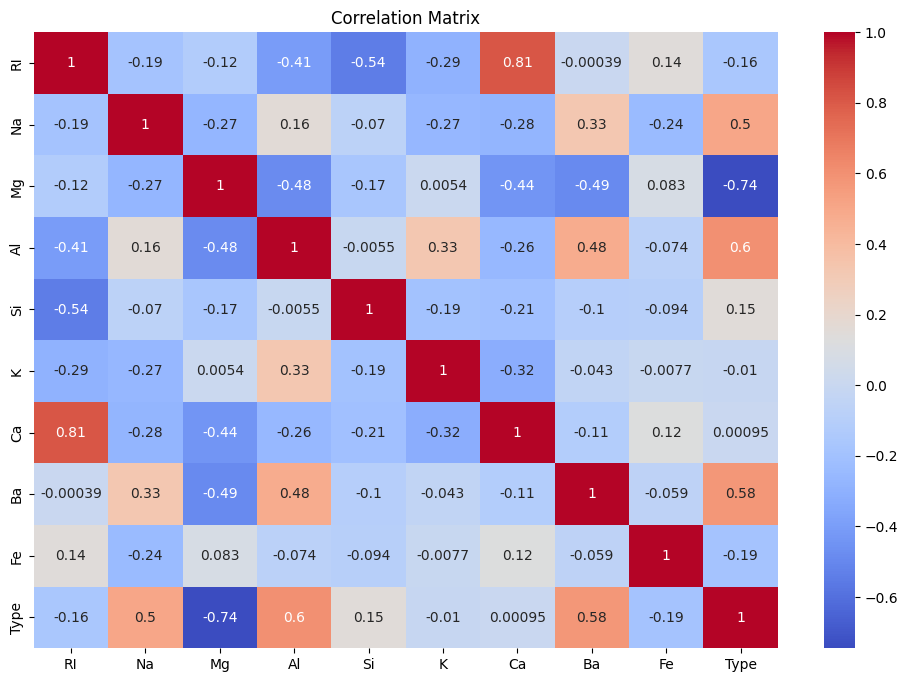

In [3]:
# Display basic statistics
print(glass_df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = glass_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

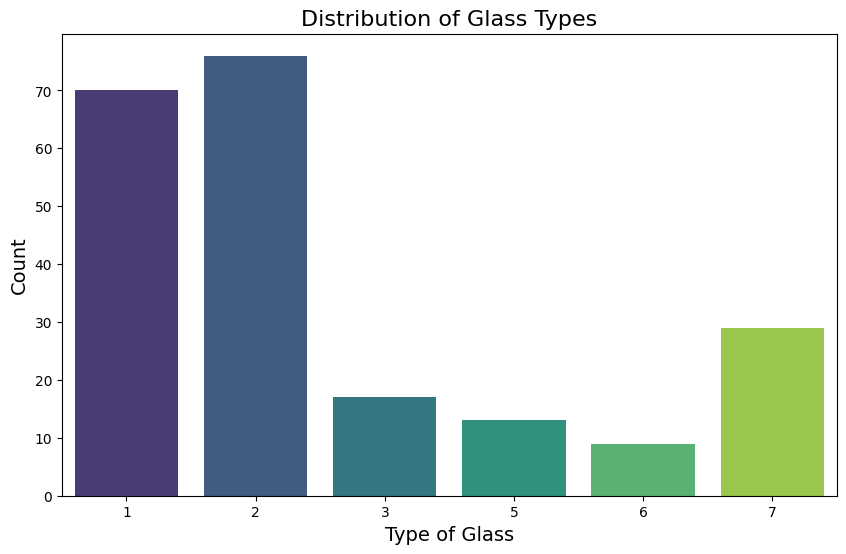

In [4]:
# Distribution of glass types
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=glass_df, palette='viridis')
plt.title('Distribution of Glass Types', fontsize=16)
plt.xlabel('Type of Glass', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


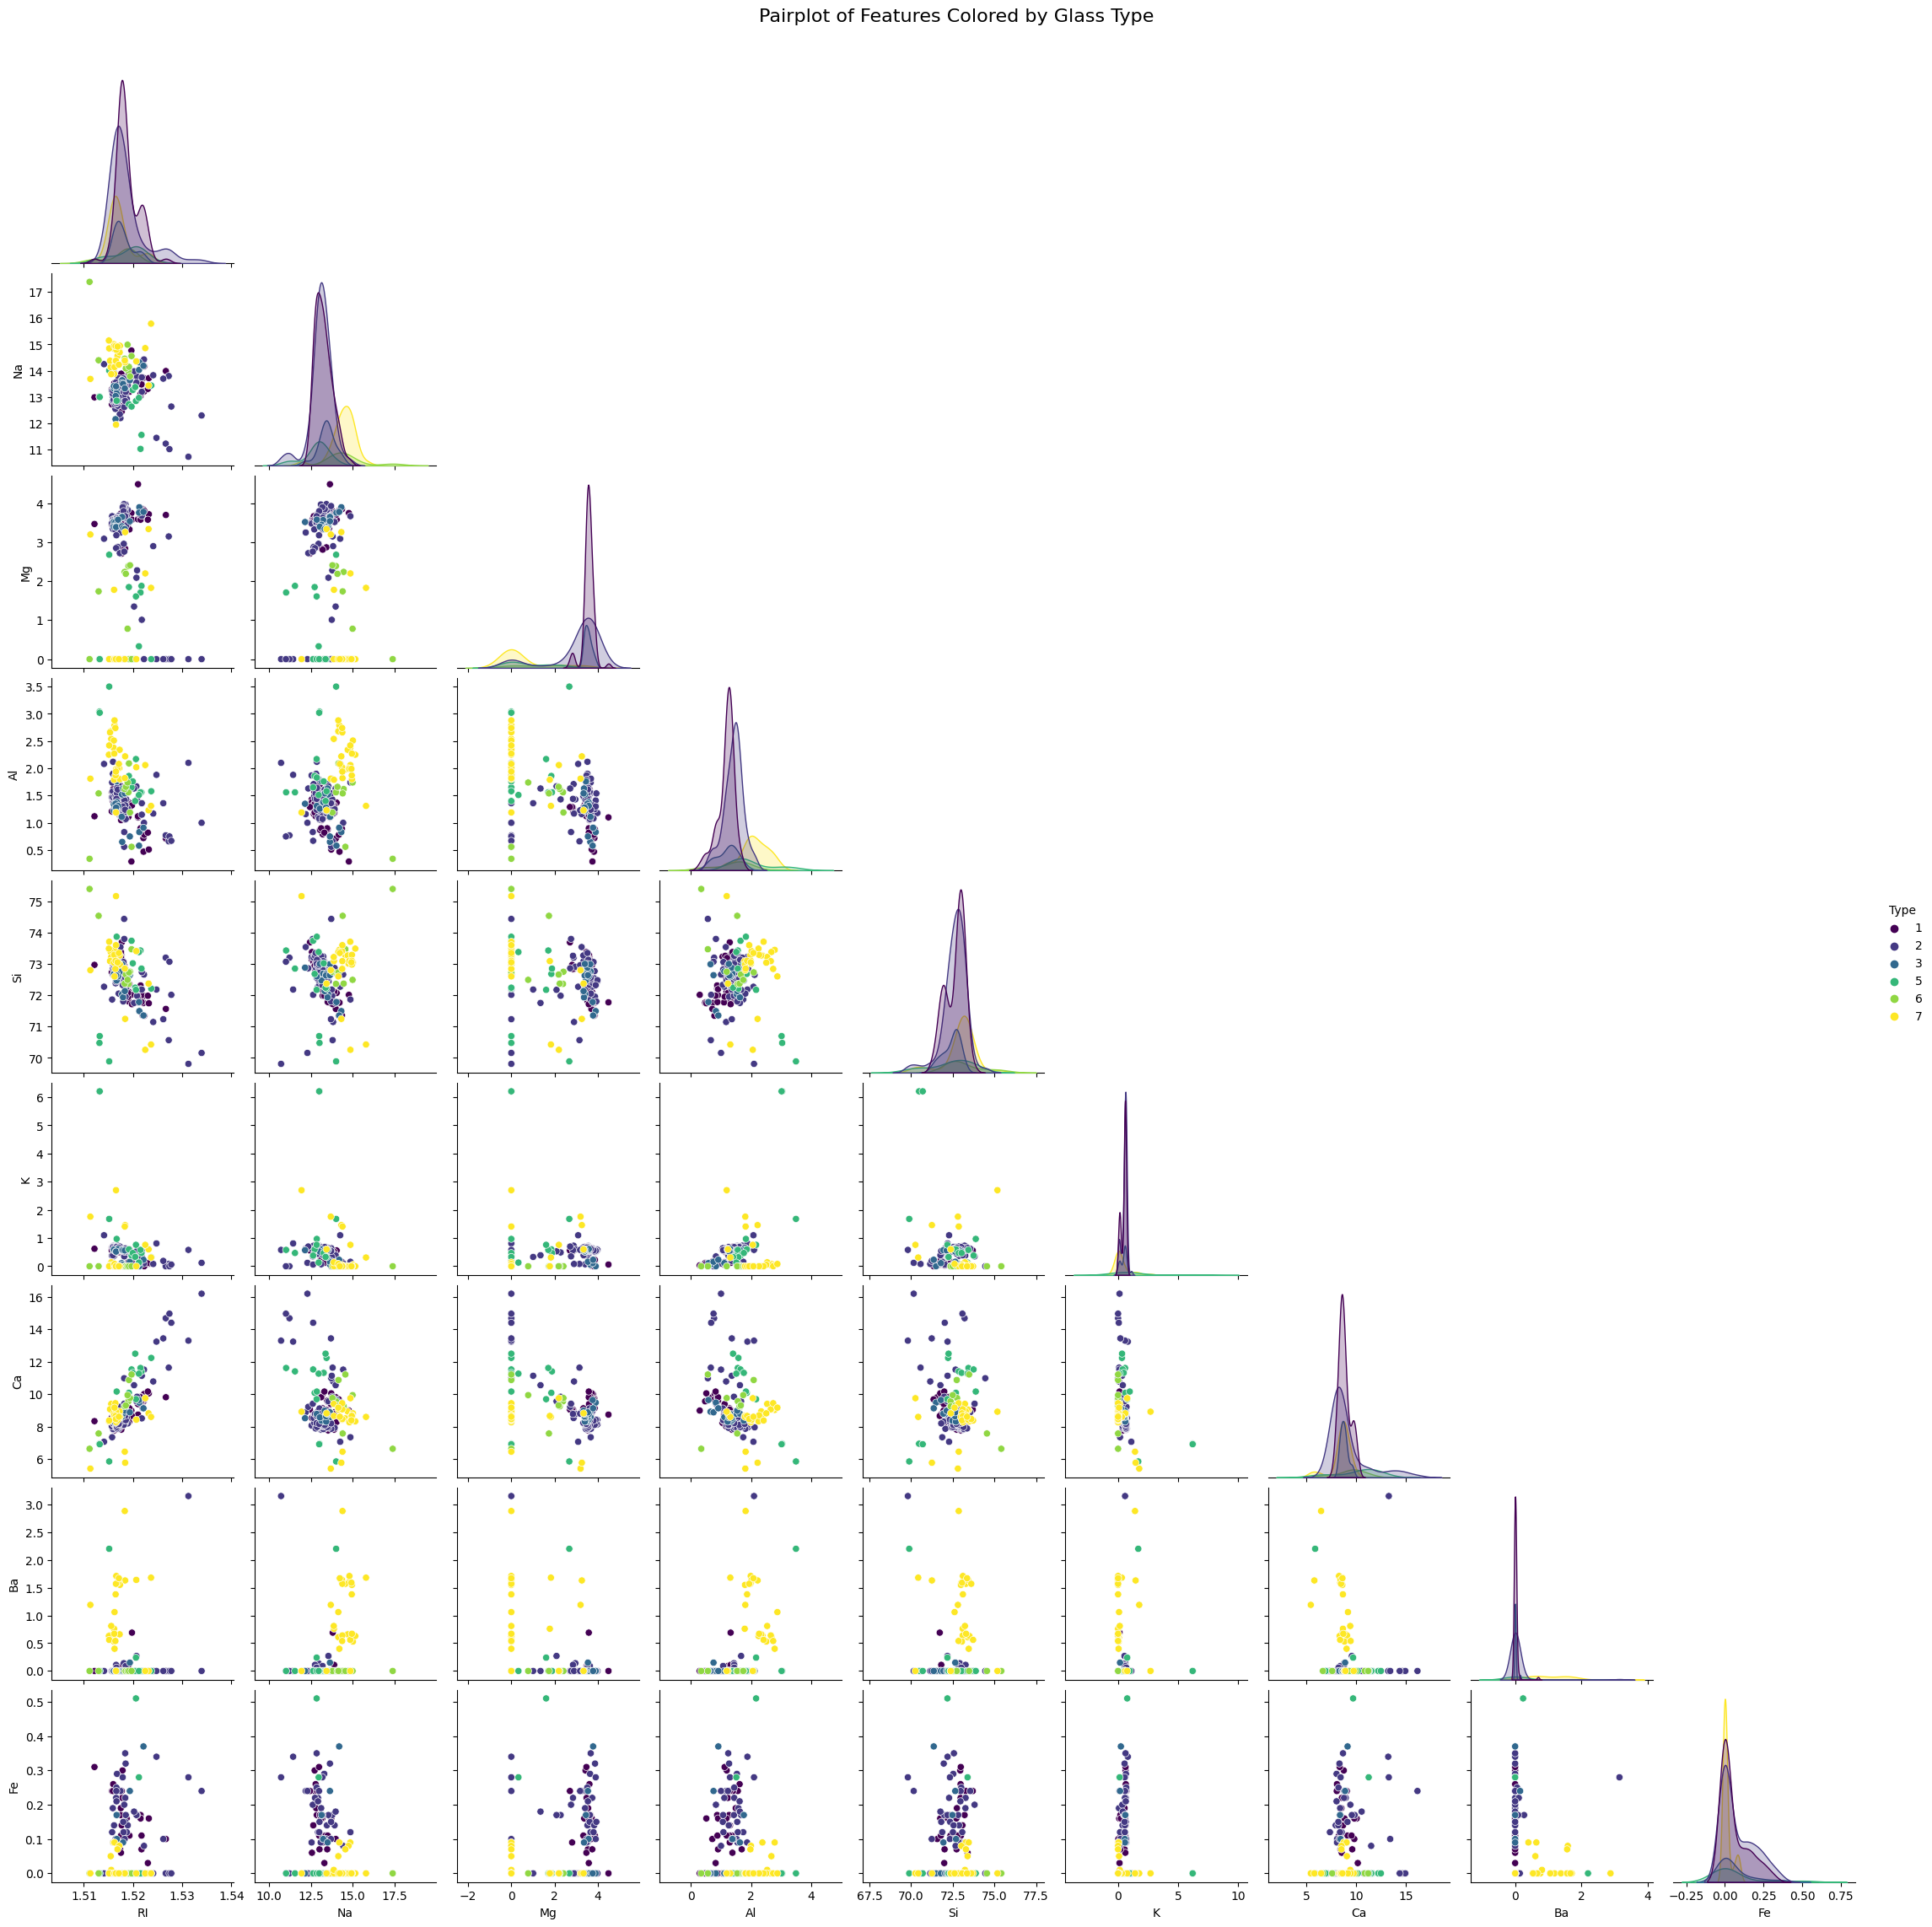

In [5]:
# Pairplot
sns.pairplot(glass_df, hue='Type', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Glass Type', y=1.02, fontsize=16)
plt.show()

In [6]:

# Define the target and features
X = glass_df.drop(columns=['Type'])
y = glass_df['Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:

# Define the preprocessor
numerical_features = glass_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = glass_df.select_dtypes(include=['object']).columns.tolist()
numerical_features.remove('Type')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the model with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', dt_classifier)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
    return scores.mean()


In [9]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Decision Tree'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)
# Check if the JSON file contains hyperparameters
if 'criterion' in best_params:
    # Use the hyperparameters from the JSON file
    dt_classifier = DecisionTreeClassifier(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    dt_classifier = DecisionTreeClassifier(**best_params)

[I 2025-02-24 22:16:07,547] A new study created in memory with name: no-name-1cc716e8-186b-4d7f-a348-286e73a587fa


Best Hyperparameters: {'model': 'Decision Tree'}


[I 2025-02-24 22:16:10,232] Trial 0 finished with value: 0.5732773109243698 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5732773109243698.
[I 2025-02-24 22:16:11,703] Trial 1 finished with value: 0.5912605042016807 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.5912605042016807.
[I 2025-02-24 22:16:13,158] Trial 2 finished with value: 0.608235294117647 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.608235294117647.
[I 2025-02-24 22:16:14,562] Trial 3 finished with value: 0.5678991596638656 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.608235294117647.
[I 20

In [10]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RI', 'Na', 'Mg', 'Al', 'Si',
                                                   'K', 'Ca', 'Ba', 'Fe']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=31,
                                        min_samples_split=10,
                                        splitter='random'))])

In [11]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.57142857 0.47058824 0.64705882 0.70588235 0.73529412]
Mean cross-validation score: 0.6260504201680672


In [12]:
# Predict on the test data
y_test_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_absolute_error
)
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # e.g., '<=50K' -> 0, '>50K' -> 1
y_test_pred_encoded = label_encoder.transform(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Regression metrics
r2 = r2_score(y_test_encoded, y_test_pred_encoded)
mae = mean_absolute_error(y_test_encoded, y_test_pred_encoded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
